In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
df = pd.read_csv("processed_final_pospay.csv", index_col=0)
df.head()

,type_of_transaction,counter_id,branch_id,date_of_transaction,hour,high_level_territory,staff_id,product_id,payment_amount,PTPOS_fee,PLN_eletricity_group,customer_ID
0,5,1,9812788,20170101,192544,5,681278801,1,102500,250,R1,534442716458
1,6,1,9812788,20170101,192737,5,681278801,1,22500,250,R1,534440552307
2,1,1,9812899,20170101,62205,5,681289901,1,52500,250,R1,535851560733
3,2,1,9812899,20170101,62328,5,681289901,1,52500,250,R1M,535850486687
4,3,1,9812899,20170101,103923,5,681289901,1,52500,250,R1M,535851495394


In [3]:
average_per_branch = df.filter(["branch_id","payment_amount"],axis=1)
average_per_branch= average_per_branch.groupby('branch_id')[['payment_amount']].sum()
avg_top_twenty=average_per_branch.sort_values(['payment_amount'],ascending=False).head(20)
avg_top_twenty.to_csv("avg_per_branch.csv")

In [4]:
average_per_customer = df.filter(['customer_ID','payment_amount'],axis=1)
average_per_customer=average_per_customer.groupby('customer_ID')[['payment_amount']].mean()

avg_per_cust=average_per_customer.sort_values(['payment_amount'],ascending=False).head(20)
avg_per_cust.to_csv("avg_per_customer.csv")

In [5]:
df['type_of_transaction'].nunique()


7898

In [6]:
average_per_type_of_transaction = df.filter(['type_of_transaction','payment_amount'],axis=1)
average_per_type_of_transaction=average_per_type_of_transaction.groupby('type_of_transaction')[['payment_amount']].mean()
average_per_type_of_transaction.sort_values(['payment_amount'],ascending=False).head(5)

,payment_amount
type_of_transaction,
10289,5.002500e+06
2760,3.710340e+06
4943,1.520000e+06
4535,1.040500e+06
11829,1.002500e+06


In [7]:
trans_cust_avg= df.groupby('customer_ID')[['type_of_transaction','payment_amount']].mean()
trans_cust_avg= trans_cust_avg.head(20)
trans_cust_avg=trans_cust_avg.sort_values(['payment_amount'],ascending=False)
trans_cust_avg.head(20)
#trans_cust_avg.to_csv("trans_cust_avg.csv")

,type_of_transaction,payment_amount
customer_ID,,
111550079934,11.00,973441.0
111550002284,34.00,502500.0
111550055573,8.00,458473.0
111550234695,7.00,202500.0
111550273418,14.00,202500.0
111550207206,33.00,202500.0
111550150781,10.00,171207.0
111550271633,30.50,109432.5
111550011523,18.00,102500.0


# Predict amount of next transaction for each customer

In [21]:
# Test and training data preparation
df = df.truncate(after=100000,axis=0)
y_data = df['payment_amount']
y_data.head(2)
y_data = y_data.astype("category")
y_data = y_data.cat.codes

In [22]:
x_data = df.copy(True)
x_data = x_data.drop(["date_of_transaction","hour","PTPOS_fee",'counter_id','branch_id','high_level_territory','staff_id','payment_amount'],axis=1)
for column in x_data:
        x_data[column] = x_data[column].astype('category')
        x_data[column] = x_data[column].cat.codes
x_data.head(2)

,type_of_transaction,product_id,PLN_eletricity_group,customer_ID
0,4,0,5,3228
1,5,0,5,3189


In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

In [24]:
def RFC(X_train,X_test, y_train ,y_test):
    clf = RandomForestClassifier(n_estimators = 10,
                                 max_features='sqrt',
                                 max_depth=None,
                                 n_jobs=-1)
    clf.fit(X_train, y_train.ravel())
    score = clf.score(X_test,y_test.ravel())
    return (clf,score)

In [25]:
X_train.describe()

,type_of_transaction,product_id,PLN_eletricity_group,customer_ID
count,7000.000000,7000.0,7000.000000,7000.000000
mean,82.451429,0.0,5.182571,4303.780143
std,105.667368,0.0,1.513320,2458.944676
min,0.000000,0.0,0.000000,0.000000
25%,14.000000,0.0,5.000000,2206.500000
50%,42.000000,0.0,5.000000,4319.500000
75%,104.250000,0.0,6.000000,6405.250000
max,586.000000,0.0,9.000000,8583.000000


In [26]:
clf,score = RFC(X_train,X_test, y_train ,y_test)

In [27]:
score

0.40953015661446185

In [39]:
def plot_importances(clf,x_data):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    labels=[]
    for x in indices:
        labels.append(x_data.columns[x])
    X=x_data

    plt.figure(figsize=(30,5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices],align="center")
    plt.xticks(range(X.shape[1]), labels)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    plt.savefig("trans-customer-model")

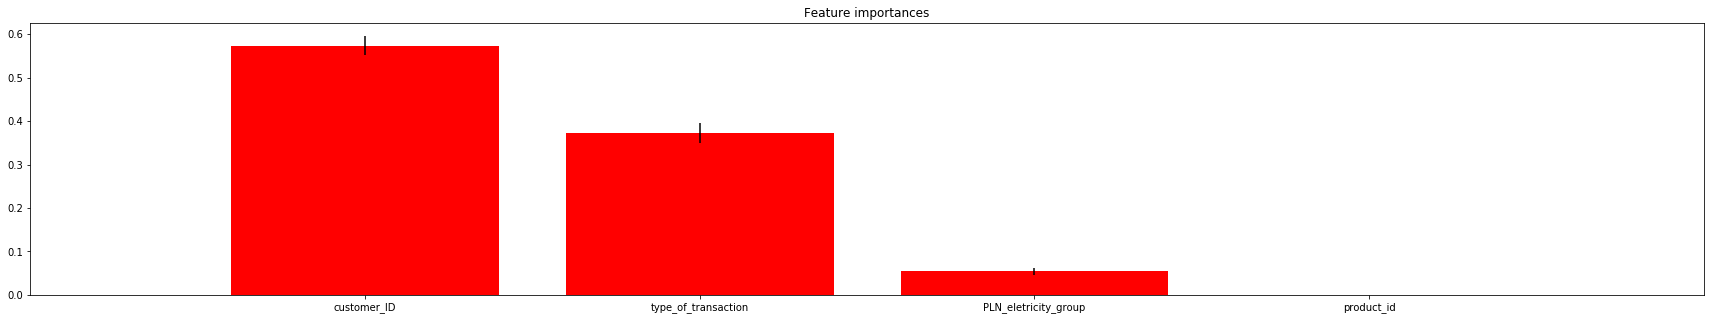

<Figure size 432x288 with 0 Axes>

In [40]:
plot_importances(clf,x_data)